# 과제#3. [평가] 이동통신 고객 이탈 예측

* 여러분은 OO 통신회사 데이터분석가 입니다.
* 00 통신회사의 올해 고객 목표는, **현재 고객수를 유지**하는 것입니다.
* 더욱 치열해진 경쟁 상황에서 고객수를 유지하는 것은 굉장히 도전적인 목표 입니다.
* 이를 위해 회사는 약정기간이 끝난 고객이 번호이동(이탈)해 가는 문제를 해결하고자 합니다.
* 그래서 에이블러 여러분에게, 어떤 고객이 번호이동(이탈)해 가는지 예측 모델링을 의뢰하였습니다.

![](https://d18lkz4dllo6v2.cloudfront.net/cumulus_uploads/entry/23964/mobile%20phones.png)

## 0.환경설정

# 평가기준
* 오류가 날 경우 도움 x --> 진짜 정 아니다 싶으면 질문 게시판 활용 --> 힌트 획득


### 1) 라이브러리 로딩

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

### 2) 데이터 로딩

In [3]:
# mobile data
data_path = "https://raw.githubusercontent.com/DA4BAM/dataset/master/mobile_NA2.csv"
data = pd.read_csv(data_path)
data.head()

,id,COLLEGE,INCOME,OVERAGE,LEFTOVER,HOUSE,HANDSET_PRICE,OVER_15MINS_CALLS_PER_MONTH,AVERAGE_CALL_DURATION,REPORTED_SATISFACTION,REPORTED_USAGE_LEVEL,CONSIDERING_CHANGE_OF_PLAN,CHURN
0,544,1,47711,183,17,730589.0,192,19,5,unsat,little,considering,0
1,689,0,74132,191,43,535092.0,349,15,2,unsat,very_little,no,1
2,3134,1,150419,0,14,204004.0,682,0,6,unsat,very_high,considering,0
3,12523,0,159567,0,58,281969.0,634,1,1,very_unsat,very_high,never_thought,0
4,2374,1,23392,0,0,216707.0,233,0,15,unsat,very_little,no,1


|변수 명|내용|구분|
|	----	|	----	|	----	|
|	COLLEGE	|	대학졸업 여부(1,0) - 범주	|		|
|	INCOME	|	연 수입액(달러)	|		|
|	OVERAGE	|	월 초과사용 시간(분)	|		|
|	LEFTOVER	|	월 사용 잔여시간비율(%)	|		|
|	HOUSE	|	집 가격(달러)	|		|
|	HANDSET_PRICE	|	핸드폰 가격(달러)	|		|
|	OVER_15MINS_CALLS_PER_MONTH	|	 평균 장기통화(15분 이상) 횟수	|		|
|	AVERAGE_CALL_DURATION	|	평균 통화시간(분)	|		|
|	REPORTED_SATISFACTION	|	만족도 설문('very_unsat', 'unsat', 'avg', 'sat', 'very_sat' ) - 범주	|		|
|	REPORTED_USAGE_LEVEL	|	사용 수준 설문('very_little', 'little', 'avg', 'high', 'very_high') - 범주	|		|
|	CONSIDERING_CHANGE_OF_PLAN	|	변경 계획 설문('never_thought', 'no', 'perhaps', 'considering',   'actively_looking_into_it') - 범주	|		|
|	**CHURN**	|	이탈여부(1 : 이탈, 0 : 잔류)	|	**Target**	|


----

## 1.데이터 탐색

## 2.데이터 전처리 

In [4]:
target = 'CHURN'

### 2.1 데이터 정리

* feature와 , target으로 분할

In [29]:
x = data.drop(target, axis = 1)
y = data.loc[:, target]

* 불필요한 feature 제거
    * 제거해야 할 feature를 선정하고 제거하시오. 제거 이유를 주석으로 기술합니다.

In [30]:
list(x)

['id',
 'COLLEGE',
 'INCOME',
 'OVERAGE',
 'LEFTOVER',
 'HOUSE',
 'HANDSET_PRICE',
 'OVER_15MINS_CALLS_PER_MONTH',
 'AVERAGE_CALL_DURATION',
 'REPORTED_SATISFACTION',
 'REPORTED_USAGE_LEVEL',
 'CONSIDERING_CHANGE_OF_PLAN']

In [31]:
# ID인 경우 순수하게 고객의 정보이기 때문에 학습에 필요가 없을 것이라 생각하여 제거했습니다.
# ID는 유일한 하나의 정보이고 이탈과 전혀 관련이 없기 때문에 삭제했습니다.
x.drop("id", axis=1, inplace=True)

### 2.2 NaN에 대한 조치
* 데이터에 포함된 NaN에 대해서 조치 방법을 결정하고 적용합니다.
* **조치방법을 결정한 이유**를 주석으로 기술합니다.

##### 오류로 인해 "REPORTED_SATISFACTION"을 먼저 가변수화 하겠습니다.

In [32]:
# REPORTED_SATISFACTION 수치화 --> map
x['REPORTED_SATISFACTION'] = x['REPORTED_SATISFACTION'].map({'very_unsat': 0
                                                                     , 'unsat': 1
                                                                    , "avg": 2,
                                                                    "sat": 3,
                                                                    "very_sat": 4})


In [33]:
x.isna().sum()

COLLEGE                          0
INCOME                           0
OVERAGE                          0
LEFTOVER                         0
HOUSE                          215
HANDSET_PRICE                    0
OVER_15MINS_CALLS_PER_MONTH      0
AVERAGE_CALL_DURATION            0
REPORTED_SATISFACTION           38
REPORTED_USAGE_LEVEL             0
CONSIDERING_CHANGE_OF_PLAN       0
dtype: int64

In [34]:
# HOUSE의 값의 분포를 보니 다양합니다.
# 그래서 저는 method="ffill"을 사용했습니다.
x["HOUSE"].describe() , x["HOUSE"].value_counts()

(count     17785.000000
 mean     492950.532696
 std      252175.173507
 min      150015.000000
 25%      263876.000000
 50%      452277.000000
 75%      701460.000000
 max      999970.000000
 Name: HOUSE, dtype: float64,
 199373.0    3
 290785.0    3
 289735.0    3
 297283.0    3
 169357.0    3
            ..
 491920.0    1
 538464.0    1
 283824.0    1
 225825.0    1
 897894.0    1
 Name: HOUSE, Length: 17558, dtype: int64)

In [35]:
x["HOUSE"].fillna(method="ffill",inplace=True)

In [36]:
x.isna().sum()

COLLEGE                         0
INCOME                          0
OVERAGE                         0
LEFTOVER                        0
HOUSE                           0
HANDSET_PRICE                   0
OVER_15MINS_CALLS_PER_MONTH     0
AVERAGE_CALL_DURATION           0
REPORTED_SATISFACTION          38
REPORTED_USAGE_LEVEL            0
CONSIDERING_CHANGE_OF_PLAN      0
dtype: int64

In [38]:
# REPORTED_SATISFACTION 값의 분포를 보니 0의 비중이 높습니다.
# 그리고 null값의 비율도 적기 때문에 저는 0값으로 채우겠습니다.
x["REPORTED_SATISFACTION"].value_counts()

0.0    7072
4.0    4562
1.0    3590
2.0    1806
3.0     932
Name: REPORTED_SATISFACTION, dtype: int64

In [39]:
x["REPORTED_SATISFACTION"].fillna(0.0,inplace=True)

In [40]:
x.isna().sum()

COLLEGE                        0
INCOME                         0
OVERAGE                        0
LEFTOVER                       0
HOUSE                          0
HANDSET_PRICE                  0
OVER_15MINS_CALLS_PER_MONTH    0
AVERAGE_CALL_DURATION          0
REPORTED_SATISFACTION          0
REPORTED_USAGE_LEVEL           0
CONSIDERING_CHANGE_OF_PLAN     0
dtype: int64

### 2.3 (옵션) 추가변수 도출
* 기존 데이터셋의 변수를 이용하여 추가로 도출할 수 있는 변수가 있다면 수행합니다.
* 추가변수 생성시, 이유에 대해서 **주석**으로 기술합니다.

### 2.4 가변수화
* 범주형 데이터이면서 값이 0,1 로 되어 있는 것이 아니라면, 가변수화를 수행해야 합니다.
* 대상이 되는 변수에 대해서 가변수화를 수행해주세요.

In [41]:
# REPORTED_SATISFACTION, REPORTED_USAGE_LEVEL, CONSIDERING_CHANGE_OF_PLAN 가변수화


# REPORTED_SATISFACTION 수치화 --> get_dumy
x = pd.get_dummies(data=x, columns=["REPORTED_SATISFACTION"], drop_first=True)


# REPORTED_USAGE_LEVEL 수치화 --> get_dumy
x['REPORTED_USAGE_LEVEL'] = x['REPORTED_USAGE_LEVEL'].map({'little': 0,
                                                           'very_little': 1,
                                                           "avg": 2,
                                                           "very_high": 3,
                                                           "high": 4})

x = pd.get_dummies(data=x, columns=["REPORTED_USAGE_LEVEL"], drop_first=True)



# CONSIDERING_CHANGE_OF_PLAN 수치화 --> get_dumy
x['CONSIDERING_CHANGE_OF_PLAN'] = x['CONSIDERING_CHANGE_OF_PLAN'].map({'never_thought': 0
                                                                     , 'no': 1
                                                                    , "perhaps": 2,
                                                                    "considering": 3,
                                                                    "actively_looking_into_it": 4})

x = pd.get_dummies(data=x, columns=["CONSIDERING_CHANGE_OF_PLAN"], drop_first=True)

In [42]:
x.head()

,COLLEGE,INCOME,OVERAGE,LEFTOVER,HOUSE,HANDSET_PRICE,OVER_15MINS_CALLS_PER_MONTH,AVERAGE_CALL_DURATION,REPORTED_SATISFACTION_1.0,REPORTED_SATISFACTION_2.0,REPORTED_SATISFACTION_3.0,REPORTED_SATISFACTION_4.0,REPORTED_USAGE_LEVEL_1,REPORTED_USAGE_LEVEL_2,REPORTED_USAGE_LEVEL_3,REPORTED_USAGE_LEVEL_4,CONSIDERING_CHANGE_OF_PLAN_1,CONSIDERING_CHANGE_OF_PLAN_2,CONSIDERING_CHANGE_OF_PLAN_3,CONSIDERING_CHANGE_OF_PLAN_4
0,1,47711,183,17,730589.0,192,19,5,1,0,0,0,0,0,0,0,0,0,1,0
1,0,74132,191,43,535092.0,349,15,2,1,0,0,0,1,0,0,0,1,0,0,0
2,1,150419,0,14,204004.0,682,0,6,1,0,0,0,0,0,1,0,0,0,1,0
3,0,159567,0,58,281969.0,634,1,1,0,0,0,0,0,0,1,0,0,0,0,0
4,1,23392,0,0,216707.0,233,0,15,1,0,0,0,1,0,0,0,1,0,0,0


### 2.5 데이터 분할

* test 3000건(test_size = 3000), random_state = 2022
* val 3000건(test_size = 3000), random_state = 2022
* train 나머지.

In [64]:
# data ==> train, test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=3000, random_state = 2022)

# test는 전체 데이터에 대한 성능 확인용

In [65]:
# train ==> train : val
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=3000, random_state = 2022)

# train 데이터의 성능을 확인 하기 위한 확인용
# 이번 코드에서는 전체 데이터 초점을 두겠습니다.
# 시간이 된다면 train의 성능 확인을 위해 코드는 입력하겠습니다.

### 2.6 (옵션)스케일링 
* 스케일링을 필요로 하는 알고리즘이 있습니다. 
* 필요하다고 판단될때 수행합니다.

In [66]:
# 스케일링

from sklearn.preprocessing import MinMaxScaler
col_x = list(x)
scaler = MinMaxScaler()

x_train_s = scaler.fit_transform(x_train)
x_val_s = scaler.transform(x_val)
x_test_s = scaler.transform(x_test)

## 3.모델링1 : 머신러닝

### 3.1 모델링을 위한 함수 불러오기

* **꼭 필요한 라이브러리 혹은 함수**만 불러옵니다. 무조건 다 불러오는 것은 지양해주세요.

In [67]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier,plot_importance
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

import matplotlib.pyplot as plt

### 3.2 모델링
* 최소 3개 이상의 알고리즘을 선정합니다.(알고리즘에는 최소 1개 이상의 앙상블 기법을 포함)
    * 아래 주어진 목록 이외의 알고리즘을 선정해도 좋습니다.
* 각 알고리즘별 튜닝을 수행하여 최적의 모델을 생성합니다.
    * 튜닝 방식은 GridSearchCV, RandomizedSearchCV 혹은 for loop 로 직접
    * 단, 선형회귀, 로지스틱 회귀의는 입력 변수(feature)를 조절하여 튜닝을 합니다.
    * 튜닝 과정에 대해서 주석으로 기술합니다.
* 모델링, 튜닝만 수행하는데 그치지 말고, 모델의 내용을 파악하기 위한 분석을 시도합니다. 코드 결과에 대한 분석 의견을 주석으로 기술합니다.
    * 예 : 모델 시각화 및 내용 파악, 튜닝 결과 분석 및 시각화

#### (1) LogisticRegression

In [266]:
# 각 모델의 accuracy, f1 score를 한 눈에 보기 위해 dictionary 형태로 저장
result={}

In [267]:
# LogisticRegression
model_lr = LogisticRegression()
model_lr.fit(x_train, y_train)

LogisticRegression()

In [268]:
# train 학습
test_pred_lr = model_lr.predict(x_test)

print(confusion_matrix(y_test, test_pred_lr))
print('-'*50)
print(classification_report(y_test, test_pred_lr))

print('-'*50)

# val 학습
val_pred_lr = model_lr.predict(x_val)

print(confusion_matrix(y_val, val_pred_lr))
print('-'*50)
print(classification_report(y_val, val_pred_lr))

[[973 567]
 [578 882]]
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.63      0.63      0.63      1540
           1       0.61      0.60      0.61      1460

    accuracy                           0.62      3000
   macro avg       0.62      0.62      0.62      3000
weighted avg       0.62      0.62      0.62      3000

--------------------------------------------------
[[987 533]
 [557 923]]
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.64      0.65      0.64      1520
           1       0.63      0.62      0.63      1480

    accuracy                           0.64      3000
   macro avg       0.64      0.64      0.64      3000
weighted avg       0.64      0.64      0.64      3000



In [269]:
result["LR_test"] =[accuracy_score(y_test,test_pred_lr), f1_score(y_test,test_pred_lr)]
result["LR_val"] =[accuracy_score(y_val,val_pred_lr), f1_score(y_val,val_pred_lr)] 

#### (2) DecisionTreeClassifier

In [270]:
#DecisionTreeClassifier
model_dt = DecisionTreeClassifier()

params = { 'max_depth':range(4,10)}
model_dt_gs = GridSearchCV(model_dt, param_grid = params, cv = 10,scoring = "accuracy")


In [271]:
# train 학습
model_dt_gs.fit(x_train, y_train)
# train 예측
test_pred_dt = model_dt_gs.predict(x_test)

In [272]:
# val 예측
val_pred_dt = model_dt_gs.predict(x_val)

In [274]:
result["DT_test"] =[accuracy_score(y_test,test_pred_dt), f1_score(y_test,test_pred_dt)]
result["DT_val"] =[accuracy_score(y_val,val_pred_dt), f1_score(y_val,val_pred_dt)] 

#### (3) KNN

In [275]:
# KNN
m_knn = KNeighborsClassifier()

params = {'n_neighbors':range(3,15)}
m_knn_gs = GridSearchCV(m_knn, param_grid = params)

In [276]:
# train 학습
m_knn_gs.fit(x_train_s, y_train)
# train 예측
test_pred_knn = m_knn_gs.predict(x_test_s)

In [277]:
m_knn_gs.best_params_

{'n_neighbors': 13}

In [278]:
# val 예측
val_pred_knn = m_knn_gs.predict(x_val_s)

In [279]:
result["KNN_test"] =[accuracy_score(y_test,test_pred_knn), f1_score(y_test,test_pred_knn)]
result["KNN_val"] =[accuracy_score(y_val,val_pred_knn), f1_score(y_val,val_pred_knn)] 

#### (4) SVC

In [282]:
m_svm = SVC()
# 학습 시간이 너무 걸려 범위를 대폭 줄였습니다.
params = {'C':[0.05, 0.1], 'gamma': [0.1,1]}
m_svm_gs = GridSearchCV(m_svm, param_grid = params, cv = 5)

In [283]:
# train 학습
m_svm_gs.fit(x_train_s, y_train)

# train 예측
test_pred_svm = m_svm_gs.predict(x_test_s)

In [284]:
m_svm_gs.best_params_

{'C': 0.1, 'gamma': 1}

In [285]:
# val 예측
val_pred_svm = m_svm_gs.predict(x_val_s)

In [286]:
result["SVM_test"] =[accuracy_score(y_test,test_pred_svm), f1_score(y_test,test_pred_svm)]
result["SVM_val"] =[accuracy_score(y_val,val_pred_svm), f1_score(y_val,val_pred_svm)] 

#### (5) Random Forest 

In [360]:
# RandomForestClassifier
m_rf = RandomForestClassifier()
params_rl = { 
           'max_depth' : [6, 8, 10, 12],
            }
m_rf_gs = GridSearchCV(m_rf,param_grid=params_rl,cv=5,scoring= 'accuracy')


In [362]:
# train 학습
m_rf_gs.fit(x_train,y_train)


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [6, 8, 10, 12]}, scoring='accuracy')

In [363]:
m_rf_gs.best_params_

{'max_depth': 10}

In [367]:
m_rf=RandomForestClassifier(max_depth=10)

In [368]:
# train 학습
m_rf.fit(x_train,y_train)


RandomForestClassifier(max_depth=10)

In [369]:
# train 예측
test_pred_rf = m_rf.predict(x_test)

In [370]:
# val 예측
val_pred_rf = m_rf.predict(x_test)

In [371]:
result["RF_test"] =[accuracy_score(y_test,test_pred_rf), f1_score(y_test,test_pred_rf)]
result["RF_val"] =[accuracy_score(y_val,val_pred_rf), f1_score(y_val,val_pred_rf)] 

#### (6) XGB 모델링

In [288]:
# XGB
m_xgb = XGBClassifier(objective='binary:logistic')

# 학습 시간이 너무 걸려 범위를 대폭 줄였습니다.
param_xgb ={'max_depth': range(3,6),
           "learning_rate":[0.1]}

m_xgb_gs =GridSearchCV(m_xgb, param_xgb, cv=10, scoring="accuracy",n_jobs=4)
# model_rs = RandomizedSearchCV(model, params, n_iter = 20, cv = 10)
m_xgb_gs.fit(x_train, y_train)

C:\Users\User\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:32:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weigh

In [289]:
# train 예측
test_pred_XGB = m_xgb_gs.predict(x_test)

In [290]:
# val 예측
val_pred_XGB = m_xgb_gs.predict(x_val)

In [296]:
result["XGB_test"] =[accuracy_score(y_test,test_pred_XGB), f1_score(y_test,test_pred_XGB)]
result["XGB_val"] =[accuracy_score(y_val,val_pred_XGB), f1_score(y_val,val_pred_XGB)] 

<BarContainer object of 20 artists>

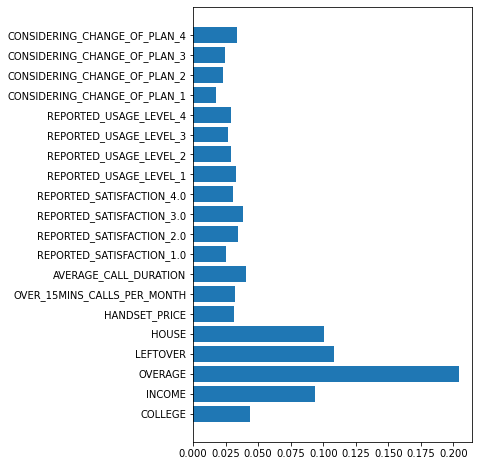

In [374]:
plt.figure(figsize=(5,8))
plt.barh(list(x),width=m_xgb_gs.best_estimator_.feature_importances_)

## 4.모델링2 : DL

### 4.1 모델링을 위한 함수 불러오기

In [320]:
from tensorflow import keras
from keras.backend import clear_session
from keras.layers import Dense,Input
from keras.models import Sequential

from keras.losses import binary_crossentropy
from keras.callbacks import EarlyStopping

### 4.2 모델링

* 딥러닝 모델을 3개 이상 생성하시오
    * 다양한 구조의 모델 3개 이상을 설계하시오. (히든레이어, 노드 수 조절)
    * 각 모델은 구조가 달라야 합니다.
    * 구조를 그렇게 구성한 이유를 주석으로 기술해 봅시다.
* 각 모델마다 
    * 구조를 summary 혹은 plot model로 확인
    * 학습 후 history plot 그리고 적절하게 학습이 되었는지 확인    

In [321]:
len(x)

18000

In [322]:
input_shape = x_train.shape[1]
print(input_shape)
batch = 100
epochs = 100

20


In [323]:
es =EarlyStopping(monitor="val_loss",
                 verbose=1,
                 patience=5,
                 restore_best_weights=True,
                 min_delta=0)

#### (1) 모델1

In [324]:
x_train.shape, y_train.shape

((12000, 20), (12000,))

In [325]:
# DL1
clear_session()

model1 = Sequential()
model1.add(Input(shape=(input_shape,)))
model1.add(Dense(1, activation="sigmoid"))
model1.compile(loss =binary_crossentropy, optimizer = 'adam',metrics=["accuracy"]) 
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 21        
                                                                 
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


In [326]:
# DL1 학습
hist1 = model1.fit(x_train, y_train, epochs = 100, validation_split=0.1,callbacks=[es], verbose=0)
hist1

Restoring model weights from the end of the best epoch: 15.
Epoch 20: early stopping


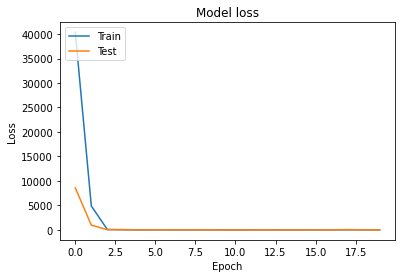

In [327]:
# DL1 시각화

plt.plot(hist1.history['loss'])
plt.plot(hist1.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [328]:
# test 예측
test_pred_dl1 = model1.predict(x_test)
for i in range(len(test_pred_dl1)):
    if test_pred_dl1[i]>=0.5:
        test_pred_dl1[i]=1
    else:
        test_pred_dl1[i]=0

In [329]:
# val 예측
val_pred_dl1 = model1.predict(x_val)
for i in range(len(val_pred_dl1)):
    if val_pred_dl1[i]>=0.5:
        val_pred_dl1[i]=1
    else:
        val_pred_dl1[i]=0

In [331]:
result["DL1_Test"] =[accuracy_score(y_test,test_pred_dl1), f1_score(y_test,test_pred_dl1)] 
result["DL1_Val"] =[accuracy_score(y_val,val_pred_dl1), f1_score(y_val,val_pred_dl1)] 

#### (2) 모델2

In [333]:
# DL2
clear_session()

il = Input(shape=(input_shape,))
hl = Dense(40,activation="relu")(il)
hl = Dense(20,activation="relu")(hl)
hl = Dense(10,activation="relu")(hl)
hl = Dense(5,activation="relu")(hl)
ol = Dense(1,activation="sigmoid")(il)

model2 = keras.models.Model(il,ol)
model2.compile(loss =binary_crossentropy, optimizer = 'adam',metrics=["accuracy"]) 
model2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20)]              0         
                                                                 
 dense_4 (Dense)             (None, 1)                 21        
                                                                 
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


In [334]:
# m2
hist2 = model2.fit(x_train, y_train, epochs = 100, validation_split=0.1,callbacks=[es], verbose=0)
hist2

Restoring model weights from the end of the best epoch: 7.
Epoch 12: early stopping


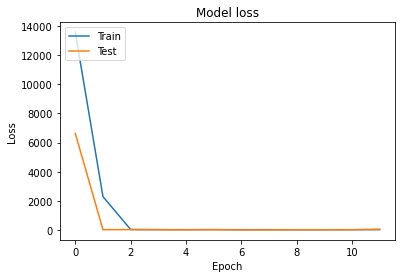

In [335]:
# DL2 시각화

plt.plot(hist2.history['loss'])
plt.plot(hist2.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [347]:
# test 예측
test_pred_dl2 = model2.predict(x_test)
for i in range(len(test_pred_dl2)):
    if test_pred_dl2[i]>=0.5:
        test_pred_dl2[i]=1
    else:
        test_pred_dl2[i]=0

In [348]:
# val 예측
val_pred_dl2 = model2.predict(x_val)
for i in range(len(val_pred_dl2)):
    if val_pred_dl2[i]>=0.5:
        val_pred_dl2[i]=1
    else:
        val_pred_dl2[i]=0

In [349]:
result["DL2_Test"] =[accuracy_score(y_test,test_pred_dl2), f1_score(y_test,test_pred_dl2)] 
result["DL2_Val"] =[accuracy_score(y_val,val_pred_dl2), f1_score(y_val,val_pred_dl2)] 

#### (3) 모델3

In [339]:
# DL3
clear_session()

il = Input(shape=(input_shape,))
hl = Dense(40,activation="relu")(il)
hl = Dense(80,activation="relu")(hl)
hl = Dense(40,activation="relu")(il)
hl = Dense(20,activation="relu")(il)
hl = Dense(10,activation="relu")(il)
hl = Dense(5,activation="relu")(il)
hl = Dense(2,activation="relu")(il)
ol = Dense(1,activation="sigmoid")(il)

model3 = keras.models.Model(il,ol)
model3.compile(loss =binary_crossentropy, optimizer = 'adam',metrics=["accuracy"]) 
model3.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20)]              0         
                                                                 
 dense_7 (Dense)             (None, 1)                 21        
                                                                 
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


In [340]:
# m3
hist3 = model3.fit(x_train, y_train, epochs = 100, validation_split=0.1,callbacks=[es], verbose=0)
hist3

Restoring model weights from the end of the best epoch: 6.
Epoch 11: early stopping


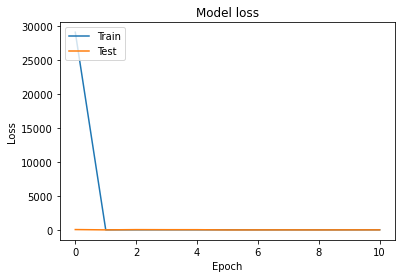

In [341]:
# DL3 시각화

plt.plot(hist3.history['loss'])
plt.plot(hist3.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [350]:
# test 예측
test_pred_dl3 = model3.predict(x_test)
for i in range(len(test_pred_dl3)):
    if test_pred_dl3[i]>=0.5:
        test_pred_dl3[i]=1
    else:
        test_pred_dl3[i]=0

In [351]:
# val 예측
val_pred_dl3 = model3.predict(x_val)
for i in range(len(val_pred_dl3)):
    if val_pred_dl3[i]>=0.5:
        val_pred_dl3[i]=1
    else:
        val_pred_dl3[i]=0

In [352]:
result["DL3_Test"] =[accuracy_score(y_test,test_pred_dl3), f1_score(y_test,test_pred_dl3)] 
result["DL3_Val"] =[accuracy_score(y_val,val_pred_dl3), f1_score(y_val,val_pred_dl3)] 

#### (4) 추가 : Locall connected

In [387]:
list(x)

['COLLEGE',
 'INCOME',
 'OVERAGE',
 'LEFTOVER',
 'HOUSE',
 'HANDSET_PRICE',
 'OVER_15MINS_CALLS_PER_MONTH',
 'AVERAGE_CALL_DURATION',
 'REPORTED_SATISFACTION_1.0',
 'REPORTED_SATISFACTION_2.0',
 'REPORTED_SATISFACTION_3.0',
 'REPORTED_SATISFACTION_4.0',
 'REPORTED_USAGE_LEVEL_1',
 'REPORTED_USAGE_LEVEL_2',
 'REPORTED_USAGE_LEVEL_3',
 'REPORTED_USAGE_LEVEL_4',
 'CONSIDERING_CHANGE_OF_PLAN_1',
 'CONSIDERING_CHANGE_OF_PLAN_2',
 'CONSIDERING_CHANGE_OF_PLAN_3',
 'CONSIDERING_CHANGE_OF_PLAN_4']

In [426]:
tr_x_economy = x_train.loc[:,["INCOME",
                           "HOUSE",
                           "HANDSET_PRICE","COLLEGE"]]

tr_x_over = x_train.loc[:,["LEFTOVER","AVERAGE_CALL_DURATION",
                           "OVER_15MINS_CALLS_PER_MONTH","REPORTED_USAGE_LEVEL_1","REPORTED_SATISFACTION_2.0"
                        ,"REPORTED_SATISFACTION_3.0","REPORTED_SATISFACTION_4.0"]]

tr_x_satice = x_train.loc[:,["REPORTED_SATISFACTION_1.0","REPORTED_SATISFACTION_2.0",
                            "REPORTED_SATISFACTION_3.0","REPORTED_SATISFACTION_4.0",
                            "CONSIDERING_CHANGE_OF_PLAN_1","CONSIDERING_CHANGE_OF_PLAN_2",
                            "CONSIDERING_CHANGE_OF_PLAN_3","CONSIDERING_CHANGE_OF_PLAN_4"]]

In [427]:
te_x_economy = x_train.loc[:,["INCOME",
                           "HOUSE",
                           "HANDSET_PRICE"]]

te_x_over = x_train.loc[:,["OVER_15MINS_CALLS_PER_MONTH","REPORTED_USAGE_LEVEL_1","REPORTED_SATISFACTION_2.0"
                        ,"REPORTED_SATISFACTION_3.0","REPORTED_SATISFACTION_4.0"]]
te_x_satice = x_train.loc[:,["REPORTED_SATISFACTION_1.0","REPORTED_SATISFACTION_2.0",
                            "REPORTED_SATISFACTION_3.0","REPORTED_SATISFACTION_4.0",
                            "CONSIDERING_CHANGE_OF_PLAN_1","CONSIDERING_CHANGE_OF_PLAN_2",
                            "CONSIDERING_CHANGE_OF_PLAN_3","CONSIDERING_CHANGE_OF_PLAN_4"]]

In [439]:
tr_x_economy.shape, tr_x_over.shape, tr_x_satice.shape, te_x_economy.shape ,te_x_over.shape, y_train.shape, y_test.shape

((12000, 4), (12000, 7), (12000, 8), (12000, 3), (12000, 5), (12000,), (3000,))

In [440]:
# 1. 세션 클리어
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.models import Model
clear_session()

# 2. 레이어 사슬처럼 엮기 : input 2개!
il_e = Input( shape=(tr_x_economy.shape[1],) )
hl_e = Dense(2, activation="relu")(il_e)

il_o = Input( shape=(tr_x_over.shape[1],) )
hl_o = Dense(2, activation="relu")(il_o)

il_s = Input( shape=(tr_x_satice.shape[1],) )
hl_s = Dense(2, activation="relu")(il_s)

cl = Concatenate()([hl_e, hl_o, hl_s])
ol = Dense(1, activation="softmax")(cl)

# 3. 모델 시작과 끝 지정
model4 = Model([il_e, il_o,il_s], ol)

# 4. 모델 컴파일
model4.compile(loss=binary_crossentropy, metrics=['accuracy'],
              optimizer="Adam")

In [462]:
hist4= model4.fit(tr_x_economy& tr_x_over& tr_x_satice, y_train, validation_split=0.1,
          epochs=100, verbose=0, callbacks=[es])
hist4

TypeError: unsupported operand type(s) for &: 'float' and 'bool'

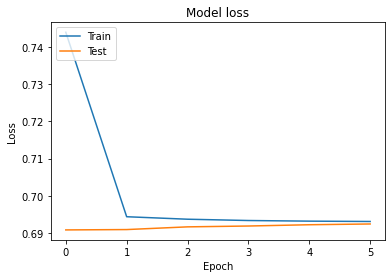

In [442]:
# DL4 시각화

plt.plot(hist4.history['loss'])
plt.plot(hist4.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [444]:
tr_x_economy.head()

,INCOME,HOUSE,HANDSET_PRICE,COLLEGE
394,50605,286997.0,287,1
2611,41146,895171.0,150,1
4383,59690,841213.0,829,1
6895,119741,691242.0,631,0
2021,45216,763090.0,174,0


In [ ]:
model4.predict(te_x_economy,te_x_over,te_x_satice)

In [ ]:
te_x_economy.bool()

In [437]:
# # test 예측
# test_pred_dl4 = model4.predict(x_train)
# for i in range(len(test_pred_dl4)):
#     if test_pred_dl4[i]>=0.5:
#         test_pred_dl4[i]=1
#     else:
#         test_pred_dl4[i]=0

In [438]:
# result["DL4_Test"] =[accuracy_score(y_test,test_pred_dl4), f1_score(y_test,test_pred_dl4)] 


## 5.성능 비교
* 총 모델이 최소한 ML 3가지, DL 3가지 입니다. 이에 대해 성능을 평가합니다.
* 평가를 위한 적절한 지표(metric)을 결정하고 비교합니다.
    * **평가지표 선정 이유**를 주석으로 기술하시오.
* 최종 모델을 **선정하게 된 근거**를 주석으로 기술하시오.

### 5.1 평가지표 결정

* 어떤 지표로 성능을 비교할지 결정합니다.
* 결정 이유를 기술합니다.

In [293]:
# 저는 Accuracy와 F1 Score를 활용하겠습니다.

In [292]:
# Accuracy를 활용하는 이유는 데이터의 양이 그래도 어느정도 되기 때문입니다.
# 또한 고객 이탈 비율이 반반이기 때문에 맞고 틀리고가 명확하기 때문입니다.
###### - 이직 데이터를 활용 할 때, 이직율이 월등히 적어서 학습을 할 때 전체 예측을 0으로만 해도 8~90프로가 보장 됐기 때문에 적절하지 않았지만
###### - 이번 데이터 셋은 반반의 비율이기 때문에 학습의 효율을 바로 볼 수 있는게 Accuracy라 생각을 하게 됐습니다.
###### - F1 Score는 부가적으로 precision과 recall의 편차를 확인 하기 위해 활용하는 참고용으로 하겠습니다.

### 5.2 성능 비교

* 성능을 비교하고, 최적의 모델을 선정하시오.
* 선정 근거를 주석으로 기술하시오.

In [372]:
print("Model \t\t acc \t\t f1")
count=1
for key, value in result.items():
    if count%2!=0:
        print("="*50)
    print(key,": \t",value)
    count+=1

Model 		 acc 		 f1
LR_test : 	 [0.6183333333333333, 0.6063939498109316]
LR_val : 	 [0.6366666666666667, 0.6287465940054496]
DT_test : 	 [0.6866666666666666, 0.7023432552248258]
DT_val : 	 [0.7176666666666667, 0.7332283464566929]
KNN_test : 	 [0.6, 0.5723449750534569]
KNN_val : 	 [0.6263333333333333, 0.596036036036036]
SVM_test : 	 [0.6416666666666667, 0.6022937476877543]
SVM_val : 	 [0.6623333333333333, 0.6243974786800148]
XGB_test : 	 [0.6833333333333333, 0.690150032615786]
XGB_val : 	 [0.7113333333333334, 0.7177314211212515]
DL1_Test : 	 [0.5973333333333334, 0.6502605674580197]
DL1_Val : 	 [0.614, 0.6662824207492796]
DL2_Test : 	 [0.6173333333333333, 0.6289592760180994]
DL2_Val : 	 [0.6416666666666667, 0.6562200191877199]
DL3_Test : 	 [0.5733333333333334, 0.6338672768878719]
DL3_Val : 	 [0.578, 0.6401364411597499]
RF_test : 	 [0.6873333333333334, 0.685656836461126]
RF_val : 	 [0.5053333333333333, 0.5059920106524634]


In [ ]:
# XGB DT의 모델을 선정 하겠습니다.
# 가장 정확도가 높게 나왔기 때문입니다.
# 그중에서도 DT가 가장 좋은 모델이라고 뽑을 수 있는 이유가 f1 score의 편차가 가장 적습니다.

### 5.3 추가 분석 및 의견

* 성능을 한눈에 비교할 수 있는 방법을 고안해서 수행해 봅시다.

* 여러분의 선정한 모델로 비즈니스 문제를 해결할 수 있을까요? 여러분의 의견을 적어 봅시다.

### 가장 큰 차이를 보이기 시작한 부분은 OVERGAE와 INCOM

- OVERGE 경우 어느 특정 사용량에서 고객이탈의 여부가 클것으로 예상이 됩니다.
- 핸드폰 가격과 집값으로도 나뉘는데 이는 아마도 경제적 즉 OVERGE의 추가 가격과 관련이 있을 것으로 예상이 됩니다.
- ICOME 또한 사용 빈도와 통화 시간으로도 영향력이 있어 (살짝 미미하지만) 경제적인 관점과 연관이 있어 보입니다.

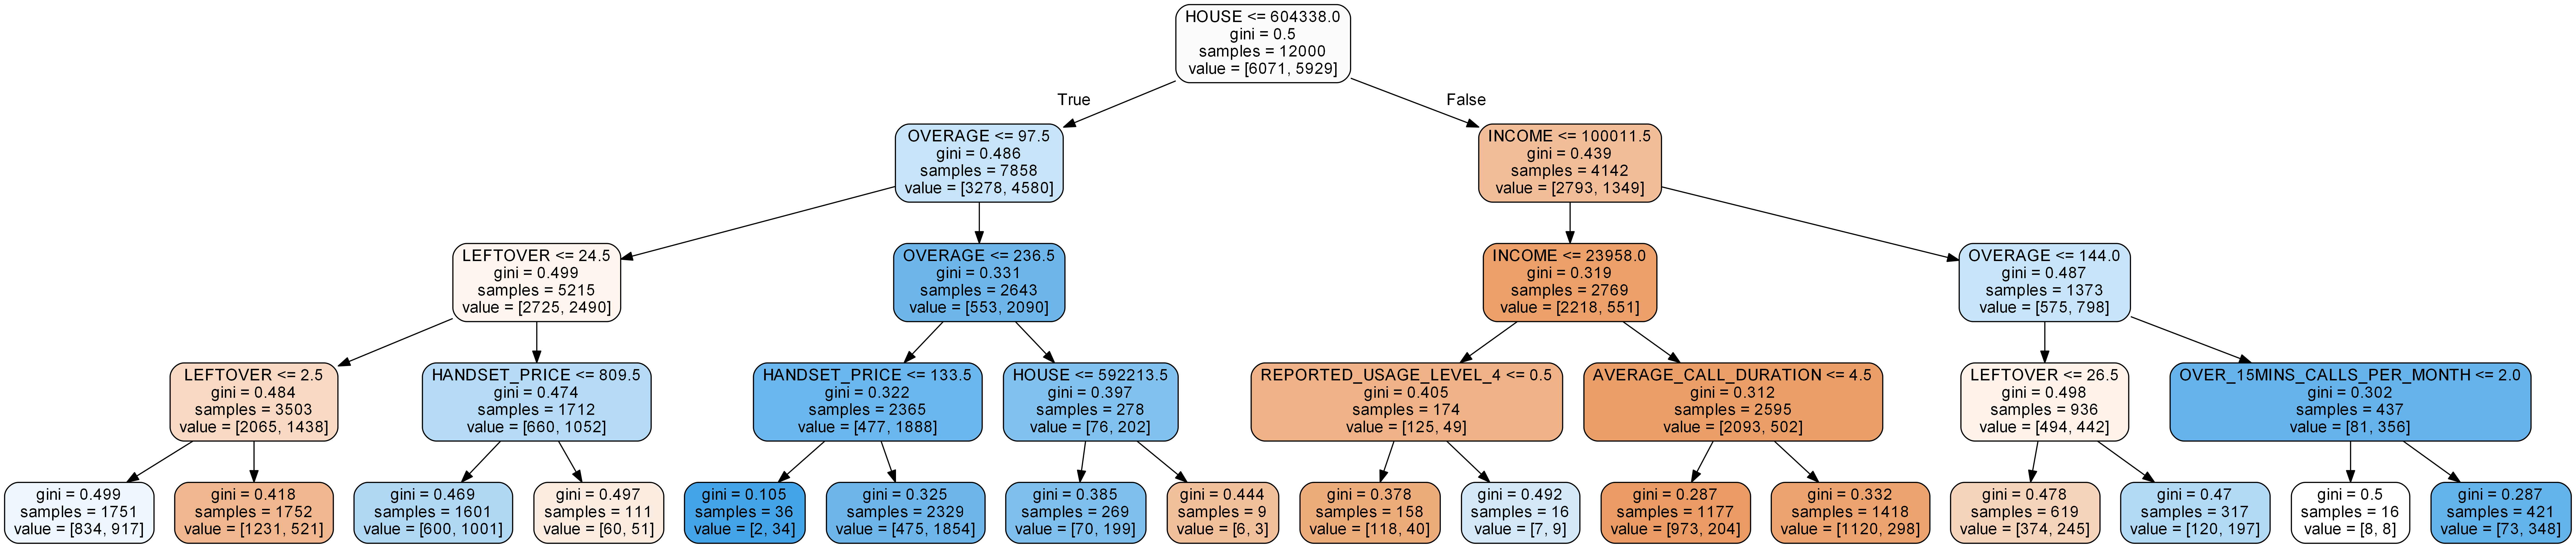

In [354]:
# 시각화
from sklearn.tree import export_graphviz

export_graphviz(model_dt_gs.best_estimator_
                , out_file = 'tree.dot'
                , feature_names = x_train.columns  # feature 이름
                , rounded = True, precision = 3, filled = True)
!dot -Tpng tree.dot -o tree.png -Gdpi=300

#이미지 파일 로딩하기.
from IPython.display import Image
Image(filename = 'tree.png', width = 800)  # 사이즈 조정.

<BarContainer object of 20 artists>

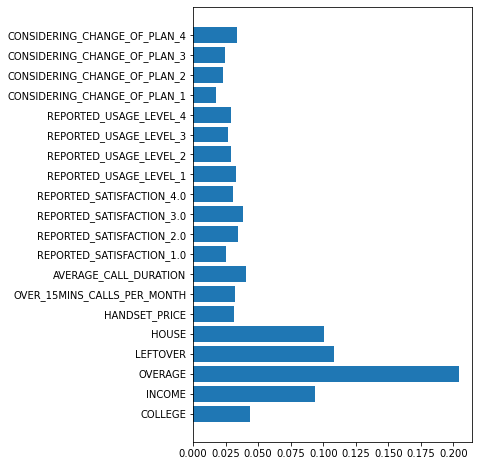

In [385]:
# XGB 최적의 피쳐 시각화

plt.figure(figsize=(5,8))
plt.barh(list(x),width=m_xgb_gs.best_estimator_.feature_importances_)


* 비즈니스 문제 해결을 위해서 더 해볼 수 있는 것은 무엇인가요?

XGB와 DT에서 둘다 공통점으로 언급 된 부분은 바로 경제적인 부분입니다.
그 중에서 OVERAGE가 가장 눈에 띄었습니다.

이를 보고 두 가지 원인이 있다고 판단됩니다.

1. 타사에 비해 초과 금액의 요금에 차이가 있다 생각합니다.
- Desicion Tree에서 보여준 것은 HOUSE, OVERAGE, REPORTED_USAGE_LEVEL 사용 수준에 따라 이탈 여부가 결정 난 것으로 보였습니다.
- XGB에 보여준 것은 OVERAGE가 압도적으로 Importance한 것을 보여줄 수 있었습니다.
- 이를 통해서 OVERAGE의 사용요금이 타사에 비해 많거나 메리트가 없다고 판단이 됩니다,

2. 어느 특정 사용량에 따른 요금이 타사와 차이가 있을 것이라 생각합니다.
- 추가되는 금액은 타사와 차이가 없을 수 있으나, 어느정도 추가로 사용했을때 요금은 타사와 차이가 있을 수 있을 것이라 생각합니다.


1과 2를 통해 종합적으로 내린 해결책은?
-> 아무래도 추가 요금, 혹은 특정 추가 요금에 따른 혜택이나 요금 조정이 필요할 것으로 생각합니다.